# Partial Dependence Plots with sklearn

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)


This notebook was created by [Sal J.M](https://www.linkedin.com/in/salim-j-m-a04534114/). Thank you so much for your contribution Sal!!

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from feature_engine.encoding import OneHotEncoder

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
from xgboost import XGBClassifier

### Load Titanic data

In [5]:
# The data can be accessed online.
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

In [6]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


### Preprocess data

 - Please note that it's important to split the data before pre-processing, which is not the case here.

In [7]:
# Replace question mark by NaN
data = data.replace('?', np.nan)


# Extract the first letter from the variable cabin
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)


# capture letter from cabin
data["cabin"] = data["cabin"].str[0]

# cabin T is a rare label, we replace it with G
data.loc[data["cabin"] == "T", "cabin"] = "G"

# impute cabin and embarked
data.fillna({
    "cabin":"M",
    "embarked": "S",
}, inplace=True)

# set pclass', 'sibsp', 'parch' columns to data type int
data[['pclass', 'sibsp', 'parch']] = data[['pclass', 'sibsp', 'parch']].astype(int)

# set fare to data type float
data['fare'] = data['fare'].astype(float)
# impute fare with the median
data['fare'] = data['fare'].fillna(data['fare'].median())

# select the features of interest only
usecols = ["pclass", "sibsp", "parch", "sex", "fare", "embarked", "cabin", "survived", ]
data = data[usecols]

# OHE for categorical features
data = OneHotEncoder(drop_last=False).fit_transform(data)

### Split Data

In [8]:
X = data.drop(columns='survived')
y = data['survived']

In [9]:
# separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


### Train XGBOOST

In [10]:
# create xgboost classifier
xgbc = XGBClassifier(n_estimators=10,
                     max_depth=1,
                     random_state=3,)

# train xgboost
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=3, ...)

In [11]:
# predict to get the model performance
y_train_proba = xgbc.predict_proba(X_train)[:, 1]
y_test_proba = xgbc.predict_proba(X_test)[:, 1]

In [12]:
# train roc-auc
roc_auc_score(y_train, y_train_proba)

0.8301767645001736

In [13]:
# test roc-auc
roc_auc_score(y_test, y_test_proba)

0.8240556385155688

### XGBoost Feature Importance

 XGboost provides feature importance which can be used as a gloabal interpretation method


In [14]:
pd.Series(xgbc.feature_importances_,
          index=X_train.columns).sort_values(ascending=False)

sex_female    0.551779
cabin_M       0.211860
pclass        0.169512
embarked_C    0.066848
cabin_C       0.000000
cabin_G       0.000000
cabin_A       0.000000
cabin_D       0.000000
cabin_E       0.000000
embarked_Q    0.000000
cabin_B       0.000000
sibsp         0.000000
embarked_S    0.000000
sex_male      0.000000
fare          0.000000
parch         0.000000
cabin_F       0.000000
dtype: float32

 - While feature importance from xgboost is a very useful interpretation method, that uncovers the most impactful features on the model prediction, it does not show the relationship of a given feature with the target variable, for example:
     - Does the output of a model increase or decrease when a feature increase?
     - What is the nature of the relationship with the target? linear, non-linear, monotonic etc.
     - PDP tries to answer these questions by plotting the feature values on the x-axis and the model outputs on the y-axis

### PDP with scikit-learn

In [15]:
from sklearn.inspection import PartialDependenceDisplay

#### PDP for the important features

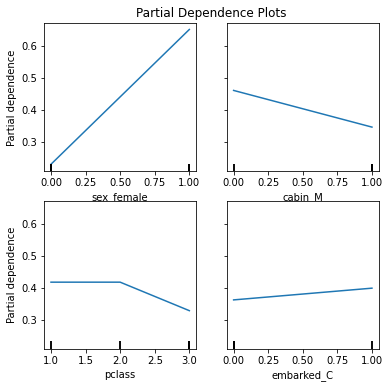

In [16]:
# plot PDP for the 4 important features (from xgboost feature importance)
important_features = ['sex_female', 'cabin_M', 'pclass', 'embarked_C']

fig, ax = plt.subplots(figsize=(6, 6))
PartialDependenceDisplay.from_estimator(xgbc, X_test, important_features, n_cols=2, ax=ax);
ax.set_title('Partial Dependence Plots')
plt.show()

 - The above PDPs illustrate the behavior of the four most influential features in our model. They offer the following insights:

     - When the 'sex_female' feature changes from 0 (male) to 1 (female), the model's output, on average, shifts from 0.2 to 0.7. This indicates that the XGBoost model has learned that females have a significantly higher probability of survival compared to males.

     - The 'cabin_M' feature exhibits a negative correlation with the model's output, suggesting that passengers in cabin class 'M' had lower chances of survival.

     - The PDP for 'pclass' demonstrates that passengers in either class 1 or 2 had better chances of survival than those in class 3.

     - Passengers who embarked in location 'C' have a slightly higher probability of survival compared to all other embarkation classes.

 - Notably, the largest variance in the model's output is observed in the top-left plot (PDP for 'sex_female'). This substantial variance corresponds to the feature's highest importance score (0.548961), making it the most influential feature in the XGBoost model."

#### PDP for two not important features

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


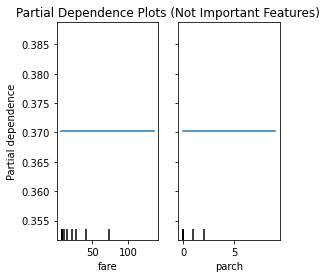

In [17]:
# PDP for some of the features that xgboost did not find important
unimportant_features = ['fare', 'parch']

fig, ax = plt.subplots(figsize=(4, 4))
PartialDependenceDisplay.from_estimator(xgbc, X_test, unimportant_features, n_cols=2, ax=ax);
ax.set_title('Partial Dependence Plots (Not Important Features)')
plt.show()

 - XGBoost assigned low feature importance scores to 'fare' and 'parch,' indicating their limited influence on the model's predictions (close to zero). This assessment is reaffirmed by their PDPs:

     - The PDP for 'fare' illustrates a flat, constant line around the value of 0.375 for all feature values. This consistency indicates that, for this model, the specific values of 'fare' have minimal impact on the final model outcome. Regardless of 'fare' values, the model's predictions remain relatively unchanged.

     - Similarly, the PDP for 'parch' exhibits a steady line near the 0.375 mark, underscoring the conclusion that, in the context of this model, 'parch' values do not significantly affect the model's predictions. The constant line reinforces the limited influence of 'parch' on the model's output

#### PDP - tweaking the plot for categorical features

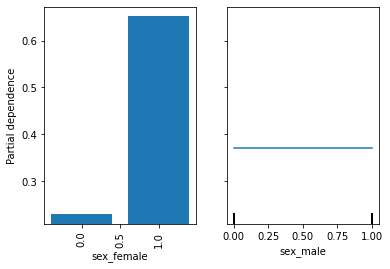

In [18]:
# If we prefer a bar plot for binary or categorical feature, this is possible
PartialDependenceDisplay.from_estimator(xgbc, X_test,
                                        ['sex_female', 'sex_male'],
                                        categorical_features=['sex_female'] ); # specify here the categorical variables

#### Partial Dependence Raw value

In [19]:
# the raw values of the partial dependence function can be obtained using the partial_dependence function

from sklearn.inspection import partial_dependence

In [20]:
results_female = partial_dependence(
    xgbc,
    X_test,
    ['sex_female']
)

In [21]:
results_female

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


{'grid_values': [array([0, 1])],
 'values': [array([0, 1])],
 'average': array([[0.22914086, 0.6515564 ]], dtype=float32)}

In [22]:
pd.DataFrame(results_female['average'], columns=['male', 'female'], index=['pdp_value']).T

,pdp_value
male,0.229141
female,0.651556


 - These are the PDP values for female and male as per the plot above (top left in the PDP for important features section)

In [23]:
results_fare = partial_dependence(
    xgbc,
    X_test,
    ['fare']
)

In [24]:
results_fare

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


{'grid_values': [array([  7.2292    ,   8.52552426,   9.82184853,  11.11817279,
          12.41449705,  13.71082131,  15.00714558,  16.30346984,
          17.5997941 ,  18.89611836,  20.19244263,  21.48876689,
          22.78509115,  24.08141541,  25.37773968,  26.67406394,
          27.9703882 ,  29.26671246,  30.56303673,  31.85936099,
          33.15568525,  34.45200952,  35.74833378,  37.04465804,
          38.3409823 ,  39.63730657,  40.93363083,  42.22995509,
          43.52627935,  44.82260362,  46.11892788,  47.41525214,
          48.7115764 ,  50.00790067,  51.30422493,  52.60054919,
          53.89687345,  55.19319772,  56.48952198,  57.78584624,
          59.08217051,  60.37849477,  61.67481903,  62.97114329,
          64.26746756,  65.56379182,  66.86011608,  68.15644034,
          69.45276461,  70.74908887,  72.04541313,  73.34173739,
          74.63806166,  75.93438592,  77.23071018,  78.52703444,
          79.82335871,  81.11968297,  82.41600723,  83.71233149,
          